In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import torch 
import torchvision
import torch.nn as nn
import scipy.io
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import time
import re
import cv2
import math


BATCH_SIZE = 4

In [3]:
# import os

# # Define the root directory
# root_dir = '/kaggle/input/aquatic-another/Test'

# list_of_folders = []

# # Walk through all directories and subdirectories
# for root, dirs, files in os.walk(root_dir):
#     for directory in dirs:
#         if('frame' in directory):
#             list_of_folders.append(os.path.join(root, directory))
#         #print(os.path.join(root, directory))
# len(list_of_folders)
# list_of_folders

In [4]:
# import os

# # Define the directory path
# directory_path = '/kaggle/input/aquatic-another/Test'

# # Get a list of all files and directories in the specified directory
# contents = os.listdir(directory_path)

# # Filter out only the directories
# folders = [folder for folder in contents if os.path.isdir(os.path.join(directory_path, folder))]

# # Print the list of folders
# for i in folders:
#     sub = os.path.join(directory_path, i)
#     aa = os.listdir(sub)
#     print(aa)
#     break

In [5]:
# #sub.split('/')[-1]
# import re

# def find_numerical_part(string):
#     # Use regex to find numerical part in the string
#     numerical_part = re.findall(r'\d+', string)[0]
#     return numerical_part

# numeral = find_numerical_part(aa[0])
# numeral

# n = sub.split('/')[-1]
# print(f'{n}_{numeral}_binary.png')

In [6]:
# import cv2
# import os
# import re

# def find_numerical_part(string):
#     # Use regex to find numerical part in the string
#     numerical_part = re.findall(r'\d+', string)[0]
#     return numerical_part

# main = os.path.join(sub,aa[0])
# numeral = find_numerical_part(aa[0])
# n = sub.split('/')[-1]
# image_path = os.path.join(main, f'{n}_{numeral}_binary.png')
# mask = cv2.imread(image_path)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# raw_imggg = os.path.join(main, f'frame_{numeral}.jpg')
# raw_img = cv2.imread(raw_imggg)

# #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# #image = (image/max(image.ravel()))*255
# # cv2.imshow('Image', image)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# print(np.unique(mask))
# # cv2.imwrite('sample.png',mask)
# # cv2.imwrite('raw.png',raw_img)

# print(mask.shape, raw_img.shape)

# mmm = np.transpose(mask, axes=(2, 0, 1))
# print(mmm.shape)

In [7]:
def find_numerical_part(string):
    # Use regex to find numerical part in the string
    numerical_part = re.findall(r'\d+', string)[0]
    return numerical_part


class aquatic_plant_dataset:
    def __init__(self, imagePaths, transforms, mode, img_target_shape = 512):
        # store the image and mask filepaths, and augmentation
        self.imagePaths = imagePaths
        #self.maskPaths = maskPaths
        self.transforms = transforms
        self.mode = mode
        self.train_list = []
        self.val_list = []
        self.test_list = []
        self.target_shape = (img_target_shape, img_target_shape)
        
        if(self.mode == 'train'):
            root_dir = self.imagePaths
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.train_list.append(os.path.join(root, directory))
        
        elif(self.mode == 'val'):
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.val_list.append(os.path.join(root, directory))
                        
        else:
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.test_list.append(os.path.join(root, directory))

        
    def __len__(self):
        if(self.mode == 'train'):
            return len(self.train_list)
        elif(self.mode == 'val'):
            return len(self.val_list)
        else:
            return len(self.test_list)
    
    def __getitem__(self,idx):
        if(self.mode == 'train'):
            folder_dir = self.train_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_binary.png')  
            binary_mask = cv2.imread(image_path)  ##reading raw image
            binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
            #print(image_path)
            
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
            #print(folder_dir, raw_path)
            #print(raw_img.shape)
        
        elif(self.mode == 'val'):
            folder_dir = self.val_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_binary.png')  
            binary_mask = cv2.imread(image_path)  ##reading raw image
            binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
            #binary_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
        
        else:
            folder_dir = self.test_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_binary.png')  
            binary_mask = cv2.imread(image_path)  ##reading raw image
            binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
            
            #binary_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
        
        if(self.transforms is not None):
            target_size = self.target_shape
            raw_img = cv2.resize(raw_img, target_size)
            binary_mask = cv2.resize(binary_mask, target_size)

            
        raw_img = np.transpose(raw_img, axes=(2, 0, 1))
        binary_mask = np.expand_dims(binary_mask, axis=0)
        #binary_mask = np.transpose(binary_mask, axes=(2, 0, 1))
        
        return torch.from_numpy(raw_img),torch.from_numpy(binary_mask)
              
        
train_dataset = aquatic_plant_dataset('/kaggle/input/final-run/Stratified_split/Train', True, 'train')
val_dataset = aquatic_plant_dataset('/kaggle/input/final-run/Stratified_split/Validation', True, 'val')
test_dataset = aquatic_plant_dataset('/kaggle/input/final-run/Stratified_split/Test', True, 'test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers = 0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = 0)   ##in testset batchsize is 1

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
len(test_loader)

50

https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py

Different models

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

# U_Net

In [ ]:
# class U_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=1):
#         super(U_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
#         self.Conv2 = conv_block(ch_in=64,ch_out=128)
#         self.Conv3 = conv_block(ch_in=128,ch_out=256)
#         self.Conv4 = conv_block(ch_in=256,ch_out=512)
#         self.Conv5 = conv_block(ch_in=512,ch_out=1024)

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.Conv1(x)
#         x2 = self.Maxpool(x1)
#         x2 = self.Conv2(x2)
#         x3 = self.Maxpool(x2)
#         x3 = self.Conv3(x3)
#         x4 = self.Maxpool(x3)
#         x4 = self.Conv4(x4)
#         x5 = self.Maxpool(x4)
#         x5 = self.Conv5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         d5 = torch.cat((x4,d5),dim=1)
        
#         d5 = self.Up_conv5(d5)
        
#         d4 = self.Up4(d5)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_conv4(d4)

#         d3 = self.Up3(d4)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_conv3(d3)

#         d2 = self.Up2(d3)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_conv2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1

# model = U_Net().to(device)
# print(model)

# R2U_Net

In [ ]:
# class R2U_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=1,t=2):
#         super(R2U_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.Upsample = nn.Upsample(scale_factor=2)

#         self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

#         self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
#         self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
#         self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
#         self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.RRCNN1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.RRCNN2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.RRCNN3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.RRCNN4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.RRCNN5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         d5 = torch.cat((x4,d5),dim=1)
#         d5 = self.Up_RRCNN5(d5)
        
#         d4 = self.Up4(d5)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_RRCNN4(d4)

#         d3 = self.Up3(d4)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_RRCNN3(d3)

#         d2 = self.Up2(d3)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_RRCNN2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
# model = R2U_Net().to(device)
# print(model)

# AttU_Net

In [ ]:
# class AttU_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=1):
#         super(AttU_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

#         self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
#         self.Conv2 = conv_block(ch_in=64,ch_out=128)
#         self.Conv3 = conv_block(ch_in=128,ch_out=256)
#         self.Conv4 = conv_block(ch_in=256,ch_out=512)
#         self.Conv5 = conv_block(ch_in=512,ch_out=1024)

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
#         self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
#         self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
#         self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
#         self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.Conv1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.Conv2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.Conv3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.Conv4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.Conv5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         x4 = self.Att5(g=d5,x=x4)
#         d5 = torch.cat((x4,d5),dim=1)        
#         d5 = self.Up_conv5(d5)
        
#         d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4,x=x3)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_conv4(d4)

#         d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3,x=x2)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_conv3(d3)

#         d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2,x=x1)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_conv2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
    
# model = AttU_Net().to(device)
# print(model)

# R2AttU_Net

In [ ]:
# class R2AttU_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=1,t=2):
#         super(R2AttU_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.Upsample = nn.Upsample(scale_factor=2)

#         self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

#         self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
#         self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
#         self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
#         self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
#         self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
#         self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
#         self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
#         self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.RRCNN1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.RRCNN2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.RRCNN3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.RRCNN4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.RRCNN5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         x4 = self.Att5(g=d5,x=x4)
#         d5 = torch.cat((x4,d5),dim=1)
#         d5 = self.Up_RRCNN5(d5)
        
#         d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4,x=x3)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_RRCNN4(d4)

#         d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3,x=x2)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_RRCNN3(d3)

#         d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2,x=x1)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_RRCNN2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
# model = R2AttU_Net().to(device)
# print(model)

# Deeplabv3

In [11]:
###Deeplabv3

from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                            DeepLabV3_ResNet50_Weights, 
                                             DeepLabV3_ResNet101_Weights, 
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )
  
#model_name == "resnet_50":
#model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
#transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

#model_name == "resnet_101":
model = deeplabv3_resnet101()   #weights=DeepLabV3_ResNet101_Weights.DEFAULT
#transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

#model_name == "mobilenet":
#model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
#transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

new_conv_layer = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
model.classifier[-1] = new_conv_layer

model = model.to(device)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# img = np.random.randint(0, 255, size=(3, 100, 100)).astype(np.uint8)
# img = torch.from_numpy(img).to(device)
# pred = model(img)

# last_layer = None
# for layer in model.children():
#     last_layer = layer
# last_layer[4]



In [12]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

lossfunc = BCEWithLogitsLoss()
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=2e-5)

In [13]:
print("Start training the network...")
startTime = time.time()

val_loss = []
train_loss = []
num_epoch = 100
best_loss = math.inf

for epoch in tqdm(range(num_epoch)):
    model.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (raw, gt)) in enumerate(train_loader):
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        #print(raw.shape, gt.shape)
        
        pred = model(raw)["out"]  #only for deeplabv3
        #pred = model(raw)
        
        loss = lossfunc(pred, gt)

        optim.zero_grad()
        loss.backward()
        optim.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        
    train_loss.append(totalTrainLoss.detach().cpu().numpy())
    
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (raw, gt) in val_loader:
            (raw, gt) = (raw.to(device), gt.to(device))
            raw = raw.to(torch.float)
            gt = gt.to(torch.float)
            
            pred = model(raw)["out"]   ##only for deeplabv3
            #pred = model(raw)
            
            curr_loss = lossfunc(pred, gt)
            totalTestLoss += curr_loss
    val_loss.append(totalTestLoss.detach().cpu().numpy()) 
    
    if(totalTestLoss<best_loss):
        print(f'Saving best weight at epoch: {epoch}.......')
        torch.save(model.state_dict(), 'model_weights.pth')    
        best_loss = totalTestLoss
            
    print(f"Train loss: {totalTrainLoss/i}, Val loss: {totalTestLoss/i}")
    
    print("EPOCH: {}/{}".format(epoch + 1, num_epoch))
    
    #print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("total time taken to train the model: {:.2f}s".format(endTime - startTime))

Start training the network...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving best weight at epoch: 0.......


  1%|          | 1/100 [01:02<1:43:14, 62.57s/it]

Train loss: 0.6078988909721375, Val loss: 2.8725762367248535
EPOCH: 1/100
Saving best weight at epoch: 1.......


  2%|▏         | 2/100 [02:06<1:43:39, 63.46s/it]

Train loss: 0.4469136893749237, Val loss: 0.45992252230644226
EPOCH: 2/100


  3%|▎         | 3/100 [03:10<1:42:44, 63.55s/it]

Train loss: 0.4109828472137451, Val loss: 3.7352840900421143
EPOCH: 3/100


  4%|▍         | 4/100 [04:13<1:41:39, 63.54s/it]

Train loss: 0.3778097927570343, Val loss: 0.6005297899246216
EPOCH: 4/100
Saving best weight at epoch: 4.......


  5%|▌         | 5/100 [05:17<1:40:56, 63.75s/it]

Train loss: 0.3489609658718109, Val loss: 0.3693093955516815
EPOCH: 5/100
Saving best weight at epoch: 5.......


  6%|▌         | 6/100 [06:22<1:40:03, 63.86s/it]

Train loss: 0.3317757248878479, Val loss: 0.11525776237249374
EPOCH: 6/100


  7%|▋         | 7/100 [07:25<1:38:51, 63.78s/it]

Train loss: 0.32106178998947144, Val loss: 1.0162594318389893
EPOCH: 7/100


  8%|▊         | 8/100 [08:29<1:37:37, 63.67s/it]

Train loss: 0.310519814491272, Val loss: 0.2572103440761566
EPOCH: 8/100


  9%|▉         | 9/100 [09:32<1:36:32, 63.65s/it]

Train loss: 0.2826368510723114, Val loss: 0.7843179106712341
EPOCH: 9/100


 10%|█         | 10/100 [10:36<1:35:25, 63.62s/it]

Train loss: 0.2860613167285919, Val loss: 0.22509677708148956
EPOCH: 10/100
Saving best weight at epoch: 10.......


 11%|█         | 11/100 [11:40<1:34:32, 63.74s/it]

Train loss: 0.25870218873023987, Val loss: 0.11093323677778244
EPOCH: 11/100


 12%|█▏        | 12/100 [12:43<1:33:26, 63.71s/it]

Train loss: 0.24064834415912628, Val loss: 1.3538124561309814
EPOCH: 12/100


 13%|█▎        | 13/100 [13:47<1:32:19, 63.67s/it]

Train loss: 0.23903387784957886, Val loss: 0.8014510273933411
EPOCH: 13/100


 14%|█▍        | 14/100 [14:51<1:31:13, 63.64s/it]

Train loss: 0.22006624937057495, Val loss: 0.7839678525924683
EPOCH: 14/100


 15%|█▌        | 15/100 [15:54<1:30:06, 63.61s/it]

Train loss: 0.21672433614730835, Val loss: 0.18659032881259918
EPOCH: 15/100


 16%|█▌        | 16/100 [16:58<1:29:08, 63.67s/it]

Train loss: 0.2089068591594696, Val loss: 1.5900102853775024
EPOCH: 16/100


 17%|█▋        | 17/100 [18:02<1:28:05, 63.68s/it]

Train loss: 0.21490564942359924, Val loss: 1.027361273765564
EPOCH: 17/100


 18%|█▊        | 18/100 [19:05<1:26:57, 63.63s/it]

Train loss: 0.1948307305574417, Val loss: 0.175587996840477
EPOCH: 18/100


 19%|█▉        | 19/100 [20:09<1:25:54, 63.63s/it]

Train loss: 0.19076727330684662, Val loss: 2.0143871307373047
EPOCH: 19/100


 20%|██        | 20/100 [21:12<1:24:48, 63.61s/it]

Train loss: 0.194823756814003, Val loss: 0.1769433170557022
EPOCH: 20/100


 21%|██        | 21/100 [22:16<1:23:44, 63.60s/it]

Train loss: 0.26013192534446716, Val loss: 0.21158118546009064
EPOCH: 21/100


 22%|██▏       | 22/100 [23:20<1:22:41, 63.61s/it]

Train loss: 0.33046793937683105, Val loss: 14.070148468017578
EPOCH: 22/100


 23%|██▎       | 23/100 [24:23<1:21:31, 63.53s/it]

Train loss: 0.3356693983078003, Val loss: 1.070883870124817
EPOCH: 23/100


 24%|██▍       | 24/100 [25:26<1:20:20, 63.42s/it]

Train loss: 0.33693060278892517, Val loss: 0.12538863718509674
EPOCH: 24/100


 25%|██▌       | 25/100 [26:29<1:19:14, 63.39s/it]

Train loss: 0.26146119832992554, Val loss: 0.7832680940628052
EPOCH: 25/100
Saving best weight at epoch: 25.......


 26%|██▌       | 26/100 [27:33<1:18:19, 63.51s/it]

Train loss: 0.2365361750125885, Val loss: 0.11093103140592575
EPOCH: 26/100


 27%|██▋       | 27/100 [28:36<1:17:11, 63.45s/it]

Train loss: 0.22256147861480713, Val loss: 0.17911727726459503
EPOCH: 27/100


 28%|██▊       | 28/100 [29:40<1:16:00, 63.34s/it]

Train loss: 0.21939444541931152, Val loss: 0.48909473419189453
EPOCH: 28/100


 29%|██▉       | 29/100 [30:43<1:14:56, 63.34s/it]

Train loss: 0.1987753063440323, Val loss: 0.169080913066864
EPOCH: 29/100


 30%|███       | 30/100 [31:46<1:13:53, 63.33s/it]

Train loss: 0.19959917664527893, Val loss: 0.7285342812538147
EPOCH: 30/100


 31%|███       | 31/100 [32:50<1:12:50, 63.35s/it]

Train loss: 0.1973058581352234, Val loss: 0.12580399215221405
EPOCH: 31/100
Saving best weight at epoch: 31.......


 32%|███▏      | 32/100 [33:54<1:11:59, 63.53s/it]

Train loss: 0.22512014210224152, Val loss: 0.08703859150409698
EPOCH: 32/100


 33%|███▎      | 33/100 [34:57<1:10:52, 63.47s/it]

Train loss: 0.19217078387737274, Val loss: 0.1009998694062233
EPOCH: 33/100


 34%|███▍      | 34/100 [36:00<1:09:48, 63.46s/it]

Train loss: 0.19348277151584625, Val loss: 1.2104450464248657
EPOCH: 34/100


 35%|███▌      | 35/100 [37:04<1:08:40, 63.39s/it]

Train loss: 0.26212164759635925, Val loss: 0.10682795196771622
EPOCH: 35/100


 36%|███▌      | 36/100 [38:07<1:07:32, 63.33s/it]

Train loss: 0.20983551442623138, Val loss: 0.2666468918323517
EPOCH: 36/100
Saving best weight at epoch: 36.......


 37%|███▋      | 37/100 [39:11<1:06:38, 63.48s/it]

Train loss: 0.1874845176935196, Val loss: 0.082126684486866
EPOCH: 37/100


 38%|███▊      | 38/100 [40:14<1:05:29, 63.37s/it]

Train loss: 0.18451720476150513, Val loss: 0.4482307732105255
EPOCH: 38/100


 39%|███▉      | 39/100 [41:17<1:04:23, 63.34s/it]

Train loss: 0.17652441561222076, Val loss: 34.19890594482422
EPOCH: 39/100


 40%|████      | 40/100 [42:20<1:03:23, 63.40s/it]

Train loss: 0.2270735502243042, Val loss: 10.051952362060547
EPOCH: 40/100


 41%|████      | 41/100 [43:24<1:02:20, 63.40s/it]

Train loss: 0.21273492276668549, Val loss: 0.10816001892089844
EPOCH: 41/100


 42%|████▏     | 42/100 [44:27<1:01:15, 63.37s/it]

Train loss: 0.21575243771076202, Val loss: 0.177572563290596
EPOCH: 42/100


 43%|████▎     | 43/100 [45:30<1:00:05, 63.25s/it]

Train loss: 0.27628910541534424, Val loss: 4.6674346923828125
EPOCH: 43/100


 44%|████▍     | 44/100 [46:33<58:57, 63.18s/it]  

Train loss: 0.2251153439283371, Val loss: 0.08925063163042068
EPOCH: 44/100


 45%|████▌     | 45/100 [47:36<57:50, 63.11s/it]

Train loss: 0.19719696044921875, Val loss: 0.08707720786333084
EPOCH: 45/100


 46%|████▌     | 46/100 [48:39<56:47, 63.10s/it]

Train loss: 0.17084920406341553, Val loss: 0.11123023927211761
EPOCH: 46/100


 47%|████▋     | 47/100 [49:42<55:46, 63.14s/it]

Train loss: 0.17375099658966064, Val loss: 0.09764058142900467
EPOCH: 47/100


 48%|████▊     | 48/100 [50:45<54:41, 63.11s/it]

Train loss: 0.1595722734928131, Val loss: 0.698361337184906
EPOCH: 48/100


 49%|████▉     | 49/100 [51:49<53:40, 63.15s/it]

Train loss: 0.14818352460861206, Val loss: 0.11962001770734787
EPOCH: 49/100


 50%|█████     | 50/100 [52:52<52:38, 63.17s/it]

Train loss: 0.14066630601882935, Val loss: 0.12343978136777878
EPOCH: 50/100


 51%|█████     | 51/100 [53:55<51:36, 63.19s/it]

Train loss: 0.13779959082603455, Val loss: 0.1405486911535263
EPOCH: 51/100


 52%|█████▏    | 52/100 [54:58<50:33, 63.21s/it]

Train loss: 0.13452549278736115, Val loss: 0.16263823211193085
EPOCH: 52/100


 53%|█████▎    | 53/100 [56:02<49:32, 63.25s/it]

Train loss: 0.1314784437417984, Val loss: 0.17111903429031372
EPOCH: 53/100


 54%|█████▍    | 54/100 [57:05<48:29, 63.25s/it]

Train loss: 0.13233672082424164, Val loss: 0.10971814393997192
EPOCH: 54/100


 55%|█████▌    | 55/100 [58:08<47:26, 63.25s/it]

Train loss: 0.12966537475585938, Val loss: 0.12769091129302979
EPOCH: 55/100


 56%|█████▌    | 56/100 [59:12<46:23, 63.27s/it]

Train loss: 0.1300075352191925, Val loss: 0.15313149988651276
EPOCH: 56/100


 57%|█████▋    | 57/100 [1:00:15<45:20, 63.28s/it]

Train loss: 0.12698446214199066, Val loss: 0.09517309069633484
EPOCH: 57/100


 58%|█████▊    | 58/100 [1:01:18<44:17, 63.27s/it]

Train loss: 0.12400851398706436, Val loss: 0.1239403635263443
EPOCH: 58/100


 59%|█████▉    | 59/100 [1:02:21<43:13, 63.26s/it]

Train loss: 0.12218744307756424, Val loss: 0.13972985744476318
EPOCH: 59/100


 60%|██████    | 60/100 [1:03:25<42:10, 63.25s/it]

Train loss: 0.11894003301858902, Val loss: 0.12786191701889038
EPOCH: 60/100


 61%|██████    | 61/100 [1:04:28<41:07, 63.27s/it]

Train loss: 0.1182173639535904, Val loss: 0.12107120454311371
EPOCH: 61/100


 62%|██████▏   | 62/100 [1:05:31<40:06, 63.32s/it]

Train loss: 0.12428215146064758, Val loss: 0.12718528509140015
EPOCH: 62/100


 63%|██████▎   | 63/100 [1:06:35<39:04, 63.35s/it]

Train loss: 0.12160435318946838, Val loss: 0.15030579268932343
EPOCH: 63/100


 64%|██████▍   | 64/100 [1:07:38<38:00, 63.34s/it]

Train loss: 0.1201196014881134, Val loss: 0.1386164128780365
EPOCH: 64/100


 65%|██████▌   | 65/100 [1:08:41<36:55, 63.30s/it]

Train loss: 0.11833397299051285, Val loss: 0.14763307571411133
EPOCH: 65/100


 66%|██████▌   | 66/100 [1:09:44<35:51, 63.28s/it]

Train loss: 0.11833591759204865, Val loss: 0.1703103631734848
EPOCH: 66/100


 67%|██████▋   | 67/100 [1:10:48<34:47, 63.26s/it]

Train loss: 0.11337559670209885, Val loss: 0.12597399950027466
EPOCH: 67/100


 68%|██████▊   | 68/100 [1:11:51<33:46, 63.33s/it]

Train loss: 0.1166902706027031, Val loss: 0.1250566840171814
EPOCH: 68/100


 69%|██████▉   | 69/100 [1:12:55<32:43, 63.33s/it]

Train loss: 0.11268258094787598, Val loss: 0.11689914762973785
EPOCH: 69/100


 70%|███████   | 70/100 [1:13:58<31:40, 63.36s/it]

Train loss: 0.11230940371751785, Val loss: 0.17035900056362152
EPOCH: 70/100


 71%|███████   | 71/100 [1:15:01<30:38, 63.40s/it]

Train loss: 0.11260102689266205, Val loss: 0.10378304123878479
EPOCH: 71/100


 72%|███████▏  | 72/100 [1:16:05<29:35, 63.40s/it]

Train loss: 0.11372746527194977, Val loss: 0.15285933017730713
EPOCH: 72/100


 73%|███████▎  | 73/100 [1:17:08<28:30, 63.36s/it]

Train loss: 0.12064997106790543, Val loss: 0.13230736553668976
EPOCH: 73/100


 74%|███████▍  | 74/100 [1:18:11<27:27, 63.37s/it]

Train loss: 0.11448630690574646, Val loss: 0.08424149453639984
EPOCH: 74/100


 75%|███████▌  | 75/100 [1:19:15<26:23, 63.34s/it]

Train loss: 0.10885313898324966, Val loss: 0.1797148436307907
EPOCH: 75/100


 76%|███████▌  | 76/100 [1:20:18<25:20, 63.37s/it]

Train loss: 0.10622742772102356, Val loss: 0.1940961629152298
EPOCH: 76/100


 77%|███████▋  | 77/100 [1:21:21<24:16, 63.34s/it]

Train loss: 0.1498289704322815, Val loss: 1648086.375
EPOCH: 77/100


 78%|███████▊  | 78/100 [1:22:24<23:09, 63.16s/it]

Train loss: 0.44465065002441406, Val loss: 386.2383728027344
EPOCH: 78/100


 79%|███████▉  | 79/100 [1:23:27<22:02, 62.98s/it]

Train loss: 0.302875280380249, Val loss: 0.10799216479063034
EPOCH: 79/100


 80%|████████  | 80/100 [1:24:30<20:58, 62.91s/it]

Train loss: 0.24724526703357697, Val loss: 0.19841845333576202
EPOCH: 80/100


 81%|████████  | 81/100 [1:25:32<19:54, 62.85s/it]

Train loss: 0.21986404061317444, Val loss: 0.10877572745084763
EPOCH: 81/100


 82%|████████▏ | 82/100 [1:26:35<18:49, 62.77s/it]

Train loss: 0.20892639458179474, Val loss: 0.10527626425027847
EPOCH: 82/100


 83%|████████▎ | 83/100 [1:27:38<17:46, 62.76s/it]

Train loss: 0.19450008869171143, Val loss: 0.13825556635856628
EPOCH: 83/100


 84%|████████▍ | 84/100 [1:28:40<16:43, 62.74s/it]

Train loss: 0.1906876564025879, Val loss: 0.15247686207294464
EPOCH: 84/100


 85%|████████▌ | 85/100 [1:29:43<15:41, 62.79s/it]

Train loss: 0.1664455384016037, Val loss: 0.1377037763595581
EPOCH: 85/100


 86%|████████▌ | 86/100 [1:30:46<14:39, 62.80s/it]

Train loss: 0.15439052879810333, Val loss: 0.16246668994426727
EPOCH: 86/100


 87%|████████▋ | 87/100 [1:31:49<13:36, 62.79s/it]

Train loss: 0.1458565890789032, Val loss: 0.14953388273715973
EPOCH: 87/100


 88%|████████▊ | 88/100 [1:32:52<12:33, 62.80s/it]

Train loss: 0.13889190554618835, Val loss: 0.1243007704615593
EPOCH: 88/100


 89%|████████▉ | 89/100 [1:33:54<11:30, 62.82s/it]

Train loss: 0.14088356494903564, Val loss: 0.17762155830860138
EPOCH: 89/100


 90%|█████████ | 90/100 [1:34:57<10:28, 62.80s/it]

Train loss: 0.15433131158351898, Val loss: 0.1601184755563736
EPOCH: 90/100


 91%|█████████ | 91/100 [1:36:00<09:26, 62.90s/it]

Train loss: 0.17105978727340698, Val loss: 0.1564924418926239
EPOCH: 91/100


 92%|█████████▏| 92/100 [1:37:03<08:23, 62.88s/it]

Train loss: 0.18497875332832336, Val loss: 0.4223076403141022
EPOCH: 92/100


 93%|█████████▎| 93/100 [1:38:06<07:19, 62.83s/it]

Train loss: 0.21156540513038635, Val loss: 6.638162612915039
EPOCH: 93/100


 94%|█████████▍| 94/100 [1:39:09<06:16, 62.80s/it]

Train loss: 0.21668139100074768, Val loss: 11106.32421875
EPOCH: 94/100


 95%|█████████▌| 95/100 [1:40:11<05:13, 62.76s/it]

Train loss: 0.26516908407211304, Val loss: 0.1824864000082016
EPOCH: 95/100


 96%|█████████▌| 96/100 [1:41:14<04:10, 62.69s/it]

Train loss: 0.22440722584724426, Val loss: 0.11725673824548721
EPOCH: 96/100


 97%|█████████▋| 97/100 [1:42:16<03:08, 62.68s/it]

Train loss: 0.1913994401693344, Val loss: 0.12702597677707672
EPOCH: 97/100


 98%|█████████▊| 98/100 [1:43:19<02:05, 62.68s/it]

Train loss: 0.17497336864471436, Val loss: 0.0940576121211052
EPOCH: 98/100


 99%|█████████▉| 99/100 [1:44:22<01:02, 62.70s/it]

Train loss: 0.15834850072860718, Val loss: 0.14544665813446045
EPOCH: 99/100


100%|██████████| 100/100 [1:45:25<00:00, 63.25s/it]

Train loss: 0.15969178080558777, Val loss: 0.13175024092197418
EPOCH: 100/100
total time taken to train the model: 6325.12s


# Plotting Loss curve

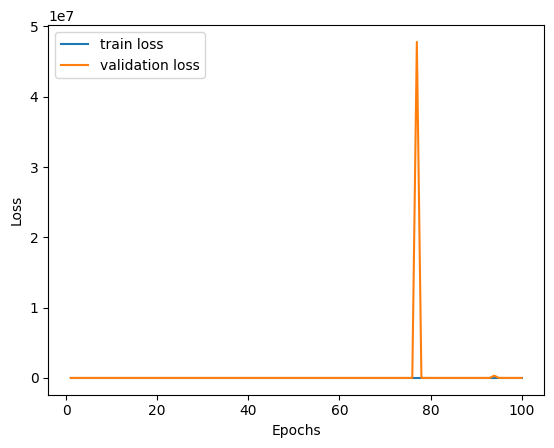

In [14]:
import matplotlib.pyplot as plt

# Example data
x = list(range(1,len(train_loss)+1))  
plt.plot(x, train_loss, label='train')  # Plot the first line and specify its label
plt.plot(x, val_loss, label='val')  # Plot the second line and specify its label

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'validation loss'])
plt.savefig('loss_curve_binary.png', dpi=300) 
plt.show()

# For Test Evaluation

In [15]:
def get_accuracy(SR,GT,threshold=0.5):
    SR = (SR > threshold)*1
    GT = GT == torch.max(GT)
    corr = torch.sum(SR==GT)
    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
    acc = float(corr)/float(tensor_size)

    return acc

# def get_sensitivity(SR,GT,threshold=0.5):
#     # Sensitivity == Recall
#     SR = (SR > threshold)*1
#     GT = GT == torch.max(GT)

#     # TP : True Positive
#     # FN : False Negative
#     TP = ((SR==1)+(GT==1))==2
#     FN = ((SR==0)+(GT==1))==2

#     SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-6)     
    
#     return SE

# def get_specificity(SR,GT,threshold=0.5):
#     SR = (SR > threshold)*1
#     GT = GT == torch.max(GT)

#     # TN : True Negative
#     # FP : False Positive
#     TN = ((SR==0)+(GT==0))==2
#     FP = ((SR==1)+(GT==0))==2

#     SP = float(torch.sum(TN))/(float(torch.sum(TN+FP)) + 1e-6)
    
#     return SP

# def get_precision(SR,GT,threshold=0.5):
#     SR = (SR > threshold)*1
#     GT = GT == torch.max(GT)

#     # TP : True Positive
#     # FP : False Positive
#     TP = ((SR==1)+(GT==1))==2
#     FP = ((SR==1)+(GT==0))==2

#     PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-6)

#     return PC

def get_F1(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SE = get_sensitivity(SR,GT,threshold=threshold)
    PC = get_precision(SR,GT,threshold=threshold)
    
    print(SE, PC)

    F1 = 2*SE*PC/(SE+PC + 1e-6)

    return F1

def calculate_f1_from_masks(y_pred, y_true, threshold=0.5):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > threshold)*1
    
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    fp = torch.sum((y_true == 0) & (y_pred == 1))
    fn = torch.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    if(f1>0):
        return f1.cpu().numpy()
    else:
        return f1


def get_JS(SR,GT,threshold=0.5):   ##same as Jaccard index, IoU
    # JS : Jaccard similarity
    SR = (SR > threshold)*1
    GT = GT == torch.max(GT)
    
    Inter = torch.sum((SR+GT)==2)
    Union = torch.sum((SR+GT)>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS

def get_DC(SR,GT,threshold=0.5):
    # DC : Dice Coefficient
    SR = (SR > threshold)*1
    GT = GT == torch.max(GT)

    Inter = torch.sum((SR+GT)==2)
    DC = float(2*Inter)/(float(torch.sum(SR)+torch.sum(GT)) + 1e-6)

    return DC

In [18]:
totaltestacc = 0
totaltestloss = 0
totaltestJS = 0
totaltestdice = 0
totaltestf1 = 0

model.load_state_dict(torch.load('model_weights.pth'))

with torch.no_grad():
    model.eval()
    # loop over the validation set
    for i, (raw, gt) in enumerate(test_loader):
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        
        pred = model(raw)["out"]  ##only for deeplabv3
        #pred = model(raw)
        
        pred = torch.sigmoid(pred)

        totaltestloss += lossfunc(pred, gt)
        totaltestacc += get_accuracy(pred, gt)
        totaltestf1 += calculate_f1_from_masks(pred, gt)
        totaltestJS += get_JS(pred, gt, threshold=0.5)
        totaltestdice += get_DC(pred, gt, threshold=0.5)  ##dice score and F1 are almost same
        #print(calculate_f1_from_masks(pred, gt))
        
print(f"total test loss {totaltestloss/i}, acc is {totaltestacc/i},f1 is {totaltestf1/i} dice is {totaltestdice/i}, JS is {totaltestJS/i}")

total test loss 0.6864316463470459, acc is 0.9138595425352758,f1 is 0.6921657088155649 dice is 0.692165710610783, JS is 0.564917366728484


In [17]:
with open('bin_scores.txt', 'w') as file:
    file.write(f'Dice co-efficient: {totaltestdice/i}\n')
    file.write(f'Jaccard index: {totaltestJS/i}\n')
    file.write(f'Accuracy: {totaltestacc/i}\n')
    file.write(f'f1_score: {totaltestf1/i}\n')
    #file.write(f'classwise jaccard: {classwisescore}\n')

In [ ]:
# g = gt.cpu().numpy()*255
# cv2.imwrite('demo.png',g)